In [38]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [39]:
# Importing Training Set
dataset_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/미스터리튜브_stat.csv')
dataset_train = dataset_train[['searchDate','subscriberCount', 'videoCount', 'favorablePercent','dailyViewCount']]

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:5]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['searchDate'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (369, 5)
All timestamps == 369
Featured selected: ['subscriberCount', 'videoCount', 'favorablePercent', 'dailyViewCount']


In [40]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (369, 4).


array([[5.2200e+04, 1.7000e+01, 0.0000e+00, 1.9743e+04],
       [5.2300e+04, 1.8000e+01, 0.0000e+00, 2.3929e+04],
       [5.2500e+04, 1.8000e+01, 0.0000e+00, 2.6015e+04],
       ...,
       [8.7000e+04, 7.4000e+01, 9.4000e+01, 5.9113e+04],
       [8.7400e+04, 7.5000e+01, 9.4000e+01, 6.8970e+04],
       [8.7600e+04, 7.5000e+01, 9.4000e+01, 5.1223e+04]])

In [41]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-2.36226473],
       [-2.34912878],
       [-2.32285687],
       [-2.30972091],
       [-2.283449  ],
       [-2.27031305],
       [-2.24404114],
       [-2.21776923],
       [-2.20463328],
       [-2.17836137],
       [-2.12581755],
       [-2.08640968],
       [-2.06013777],
       [-2.02072991],
       [-2.00759395],
       [-1.994458  ],
       [-1.96818609],
       [-1.94191418],
       [-1.92877823],
       [-1.90250632],
       [-1.88937036],
       [-1.86309845],
       [-1.8499625 ],
       [-1.81055463],
       [-1.78428272],
       [-1.77114677],
       [-1.7317389 ],
       [-1.71860295],
       [-1.705467  ],
       [-1.69233104],
       [-1.66605913],
       [-1.63978722],
       [-1.61351531],
       [-1.5872434 ],
       [-1.56097149],
       [-1.53469958],
       [-1.50842767],
       [-1.48215576],
       [-1.45588385],
       [-1.42961194],
       [-1.41647599],
       [-1.39020408],
       [-1.36393217],
       [-1.35079622],
       [-1.33766026],
       [-1

In [42]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 10   # Number of days we want top predict into the future
n_past = 170     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (190, 170, 3).
y_train shape == (190, 1).


In [43]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [44]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [45]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')
#shuffle=True,

history = model.fit(X_train, y_train, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.5869 - val_loss: 0.5458

Epoch 00001: val_loss improved from inf to 0.54578, saving model to weights.h5
Epoch 2/30
1/1 [==============================] - 0s 268ms/step - loss: 0.0666 - val_loss: 0.1910

Epoch 00002: val_loss improved from 0.54578 to 0.19097, saving model to weights.h5
Epoch 3/30
1/1 [==============================] - 0s 77ms/step - loss: 0.1966 - val_loss: 0.5048

Epoch 00003: val_loss did not improve from 0.19097
Epoch 4/30
1/1 [==============================] - 0s 73ms/step - loss: 0.0331 - val_loss: 0.9071

Epoch 00004: val_loss did not improve from 0.19097
Epoch 5/30
1/1 [==============================] - 0s 74ms/step - loss: 0.0414 - val_loss: 1.0024

Epoch 00005: val_loss did not improve from 0.19097
Epoch 6/30
1/1 [==============================] - 0s 78ms/step - loss: 0.0570 - val_loss: 0.9140

Epoch 00006: val_loss did not improve from 0.19097
Epoch 7/30
1/1 [==============================]

In [46]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [47]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [48]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

In [49]:
PREDICTIONS_FUTURE

,Open
2021-02-16,75539.187500
2021-02-17,75547.726562
2021-02-18,75555.234375
2021-02-19,75563.968750
2021-02-20,75574.593750
2021-02-21,75586.140625
2021-02-22,75595.335938
2021-02-23,75607.257812
2021-02-24,75618.390625
2021-02-25,75627.851562


In [50]:
PREDICTION_TRAIN

,Open
2021-01-28,75479.101562
2021-01-29,75487.601562
2021-01-30,75494.953125
2021-01-31,75502.023438
2021-02-01,75507.937500
2021-02-02,75513.796875
2021-02-03,75516.429688
2021-02-04,75520.320312
2021-02-05,75524.968750
2021-02-06,75530.507812


In [51]:
dataset_train

,subscriberCount,videoCount,favorablePercent,dailyViewCount
0,52200.0,17.0,0.0,19743.0
1,52300.0,18.0,0.0,23929.0
2,52500.0,18.0,0.0,26015.0
3,52600.0,18.0,0.0,25312.0
4,52800.0,18.0,0.0,25040.0
...,...,...,...,...
364,86300.0,73.0,94.0,63144.0
365,86700.0,74.0,94.0,86230.0
366,87000.0,74.0,94.0,59113.0
367,87400.0,75.0,94.0,68970.0


In [52]:
dataset_train['subscriberCount']

0      52200.0
1      52300.0
2      52500.0
3      52600.0
4      52800.0
        ...   
364    86300.0
365    86700.0
366    87000.0
367    87400.0
368    87600.0
Name: subscriberCount, Length: 369, dtype: float64

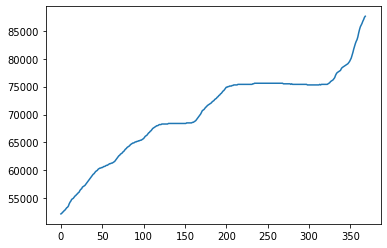

In [53]:
plt.plot(dataset_train['subscriberCount'])

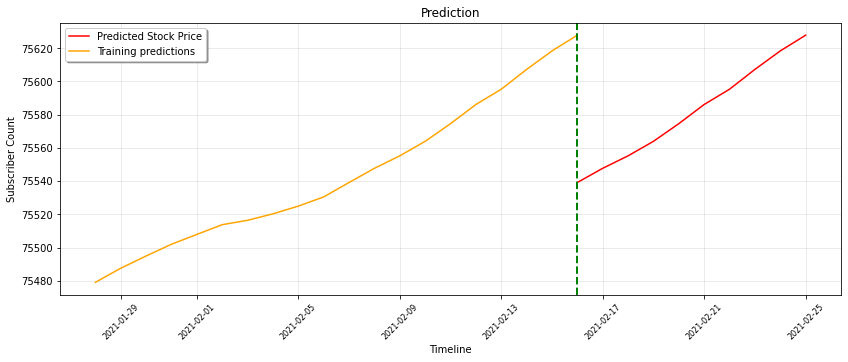

In [55]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-01-28'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
#plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediction', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Subscriber Count', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()